# Стекинг

Еще один способ строить композиции алгоритмов
Очень классная и понятная статья про стекинг от Александра Дьяконова [в его блоге](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)

**Бэггинг** - обучаем композицию алгоритмов на подвыборках, ответы усредняем

**Стекинг** - обучаем композицию алгоритмов, их ответы считаем новыми фичами - обучаем мета-алгоритм

## Блендинг
Простейший пример Стекинга это **Блендинг** обучение делится на 2 части: на одной обучаются базовые алгоритмы, на другой мета-алгоритм

Эта схема плоха тем, что надо делить обучени на части

![](images/blending.png)

## Stacking
**Классический стекинг** решает эту проблему делением на фолды, и получением значений метапризнаков на каждый фолд.
Для доп регуляризации добавляют шум в метапризнаки

![](images/stacking.png)

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
roc_auc_scorer = make_scorer(roc_auc_score)
accuracy_scorer = make_scorer(accuracy_score)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
%matplotlib inline

/Users/tylorn/envs/dmia2019/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('data/HR.csv')

In [3]:
data.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.53,2,157,3,0,1,0
1,0.86,5,262,6,0,0,0
2,0.88,7,272,4,0,1,0
3,0.87,5,223,5,0,1,0
4,0.52,2,159,3,0,1,0


In [4]:
X, y = data.drop('left', axis=1).values, data['left'].values

In [5]:
class StackingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, models, meta_model, meta_train_p=0.25, stacking_cv=3, stacking_noise=0.001, random_state=2019):
        self.models = models
        self.meta_model = meta_model
        self.meta_train_p = meta_train_p
        self.stacking_cv = stacking_cv
        self.stacking_noise = stacking_noise
        self.random_state = random_state
        if meta_train_p:
            self.fit = self._fit_blending
        else:
            self.fit = self._fit_stacking
        
    def _fit_blending(self, X, y):
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=self.meta_train_p, random_state=self.random_state)
            
        X_meta = np.empty((X_valid.shape[0], len(self.models)))
        for t, clf in enumerate(self.models):
            clf.fit(X_train, y_train)
            X_meta[:, t] = clf.predict(X_valid)

        self.meta_model.fit(X_meta, y_valid)
        return self
    
    def _fit_stacking(self, X, y):
        X_meta = self.stacking_noise * np.random.randn(X.shape[0], len(self.models))

        for t, clf in enumerate(self.models):
            X_meta[:, t] += cross_val_predict(clf, X, y, cv=self.stacking_cv, method='predict')
            clf.fit(X, y)
        self.meta_model.fit(X_meta, y)  
        return self
    
    def _X_meta(self, X):
        X_meta = np.empty((X.shape[0], len(self.models)))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        return X_meta
        
    def predict(self, X):
        return self.meta_model.predict(self._X_meta(X))
    
    def predict_proba(self, X):
        return self.meta_model.predict_proba(self._X_meta(X))

In [6]:
def compare_to_df(models, scorer):
    names = []
    scores = []
    for name, regr in models:
        score = cross_val_score(regr, X, y, cv=5, scoring=scorer).mean()
        # print(f"ROC AUC of {name} : {score}")
        names.append(name)
        scores.append(score)
    return pd.DataFrame.from_dict({"clf": names, "roc_auc": scores}).set_index('clf')

### На регрессии

In [7]:
base_models = [
    ("rf_5_clf", RandomForestRegressor(n_estimators=5)),
    ("rf_10_clf", RandomForestRegressor(n_estimators=10)),
    ("knn_5_clf", KNeighborsRegressor(n_neighbors=5)),
    ("knn_10_clf", KNeighborsRegressor(n_neighbors=10)),
    ("lightgbm_clf", LGBMRegressor()),
]
st_base_models = [clf for name, clf in base_models]
models = base_models + [
    ("blending", StackingModel(st_base_models, Ridge())),
    ("stacking", StackingModel(st_base_models, Ridge(), meta_train_p=0))
]

In [8]:
scores = compare_to_df(models, scorer=roc_auc_scorer)
scores

,roc_auc
clf,
rf_5_clf,0.591289
rf_10_clf,0.595860
knn_5_clf,0.614714
knn_10_clf,0.619862
lightgbm_clf,0.619807
blending,0.734154
stacking,0.733780


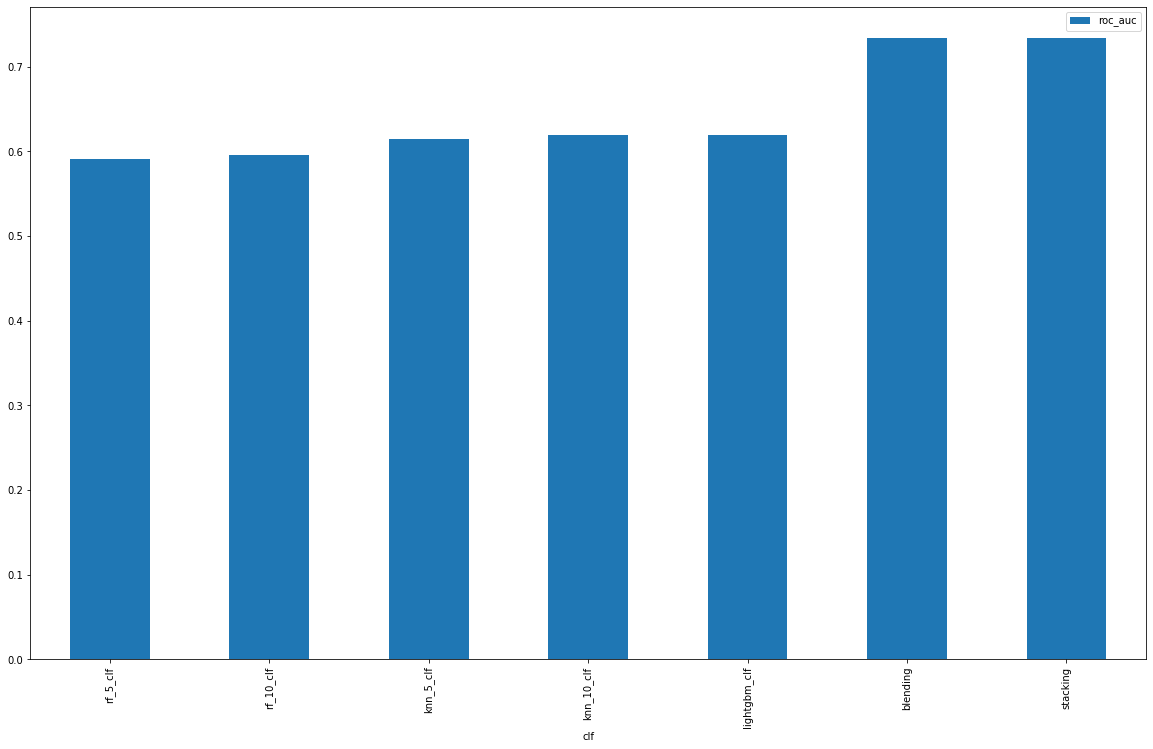

In [9]:
scores.plot(kind='bar', figsize=(20, 12))

### На классификации

In [10]:
base_models = [
    ("rf_5_clf", RandomForestClassifier(n_estimators=5)),
    ("rf_10_clf", RandomForestClassifier(n_estimators=10)),
    ("knn_5_clf", KNeighborsClassifier(n_neighbors=5)),
    ("knn_10_clf", KNeighborsClassifier(n_neighbors=10)),
    ("lightgbm_clf", LGBMClassifier()),
]
st_base_models = [clf for name, clf in base_models]
models = base_models + [
    ("blending", StackingModel(st_base_models, Ridge())),
    ("stacking", StackingModel(st_base_models, Ridge(), meta_train_p=0))
]

In [11]:
scores = compare_to_df(models, scorer=roc_auc_scorer)
scores

,roc_auc
clf,
rf_5_clf,0.665411
rf_10_clf,0.674445
knn_5_clf,0.692818
knn_10_clf,0.706228
lightgbm_clf,0.717860
blending,0.731987
stacking,0.724012


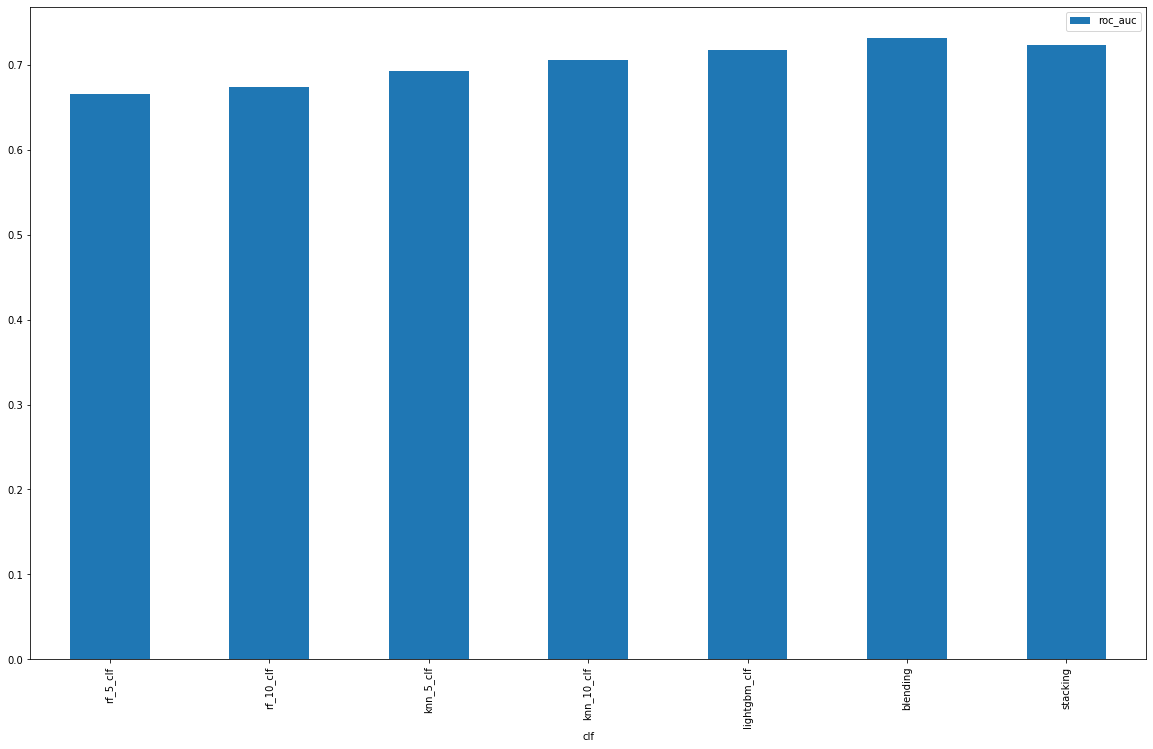

In [12]:
scores.plot(kind='bar', figsize=(20, 12))